# **CS473 - Assignment 3**

In [1]:
import numpy as np
import pandas as pd

## **Part A**

In [2]:
data = pd.read_csv('dataA_MLE.csv', header=None)
x = data[0]
y = data[1]
samples = np.array([x, y]).T
labels = data[2].astype(int)

#### 1.

In [3]:
def compute_mean(array: np.ndarray):
    sum = 0
    for i in range(len(array)):
        sum += array[i]

    return np.sum(array, axis=0) / len(array)

#### 2.

In [4]:
def compute_cov_matrix(array: np.ndarray):
    mean = compute_mean(array)
    return np.dot((array - mean).T, (array - mean)) / len(array)

#### 3.

In [5]:
covs = np.empty((3, 2, 2))
means = np.empty((3, 2))
classes = np.unique(labels)

for c in classes:
    means[c] = compute_mean(samples[labels==c])
    covs[c] = compute_cov_matrix(samples[labels==c])

    print(f'Class {c} mean & covariance matrix:')
    print(means[c], end=',\n')
    print(covs[c])
    print()

Class 0 mean & covariance matrix:
[29.20903802 16.84988855],
[[46.98591258 22.90532295]
 [22.90532295 48.63133559]]

Class 1 mean & covariance matrix:
[40.19766916 34.28109099],
[[ 9.42390491 11.48971771]
 [11.48971771 20.10805596]]

Class 2 mean & covariance matrix:
[27.55232503 34.79318037],
[[13.96874391 11.77433636]
 [11.77433636 25.28848192]]



We can observe that class 0 has larger values in the covariance matrix. We will return to this later.

#### 4.

In [6]:
from numpy.linalg import inv, det

def probability(sample, mean, cov):
    p = np.exp(-(1/2) * (sample - mean).T @ inv(cov) @ (sample - mean))
    p /= np.sqrt(((2 * np.pi) ** len(sample)) * det(cov))
    return p

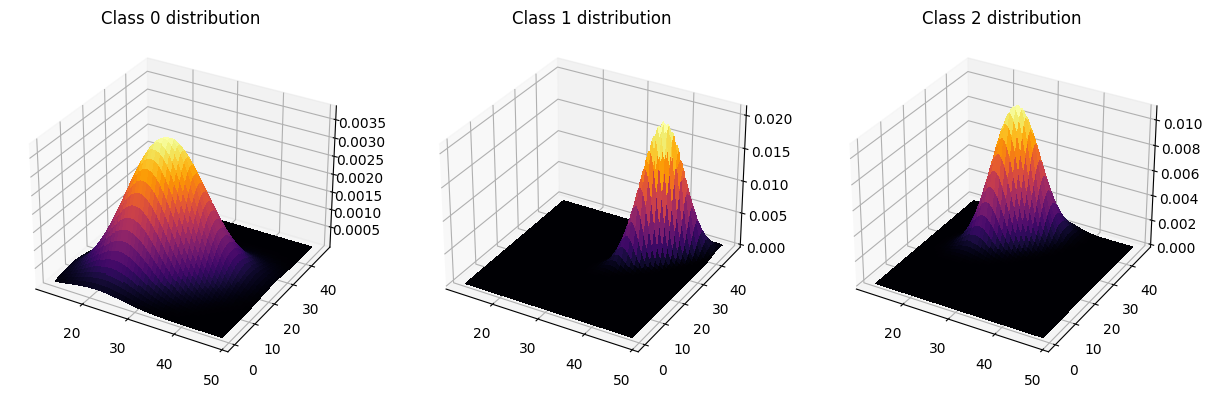

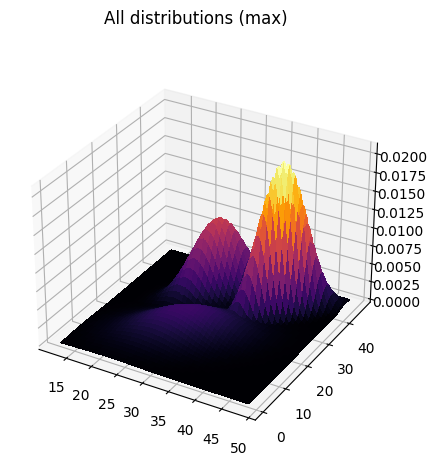

In [7]:
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
from matplotlib import cbook
from matplotlib import cm
from pyparsing import line

xlim = (np.min(x)-1, np.max(x)+1)
ylim = (np.min(y)-1, np.max(y)+1)
sample_rate = 100

xx = np.linspace(xlim[0], xlim[1], sample_rate)
yy = np.linspace(ylim[0], ylim[1], sample_rate)
xx, yy = np.meshgrid(xx, yy)

Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T
z = np.zeros((xx.shape), dtype=float)
distributions = []

for i in np.unique(labels)[::]:
    distr = np.apply_along_axis(probability, 1, Xgrid, means[i], covs[i]).reshape(xx.shape)
    z = np.maximum(z, distr)
    distributions.append(distr)

fig, ax = plt.subplots(1, 3, subplot_kw={"projection": "3d"}, figsize=(15, 5))
for i in range(3):
    ax[i].plot_surface(xx, yy, distributions[i], cmap='inferno', antialiased=False)
    ax[i].set_title(f'Class {i} distribution')

fig = plt.figure(figsize=(5, 5))
fig.suptitle('All distributions (max)')
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, z, cmap='inferno', antialiased=False)

plt.show()

Above we can see the corresponding distributions for each class. <br>
(Not sure if the question was for all 3 in the same or in different graphs, so I did both). <br>
What we can see in the 2nd graph, but maybe not so easily in the 1st, is that the distribution of class 0 compared to the other two is much more "spread-out", which indicates that it has a larger variance. This confirms our observation above - and vice-versa :)

## **Part B**

In [8]:
samples = pd.read_csv('dataB_Parzen.csv', header=None)[0]
samples = np.sort(samples)

#### 1.

In [9]:
def hypercube_win_func(x_i, c, h):
    return np.abs(x_i - c) / h <= 1/2

#### 2.

In [10]:
def gaussian_win_func(x_i, c, h):
    return np.exp(-(((x_i - c)/h)**2 / 2)) / (np.sqrt(2 * np.pi))

#### 3.

In [11]:
def win_function(x_i, c, h, ktype):
    if ktype == 'hypercube':
        return hypercube_win_func(x_i, c, h)
    elif ktype == 'gaussian':
        return gaussian_win_func(x_i, c, h)
    else:
        raise ValueError('Invalid kernel type')

#### 4.

In [12]:
def likelihood(data, x, h, ktype):
    return np.sum([win_function(x_i, x, h, ktype) for x_i in data]) / (len(data) * h)

#### 5.

a)

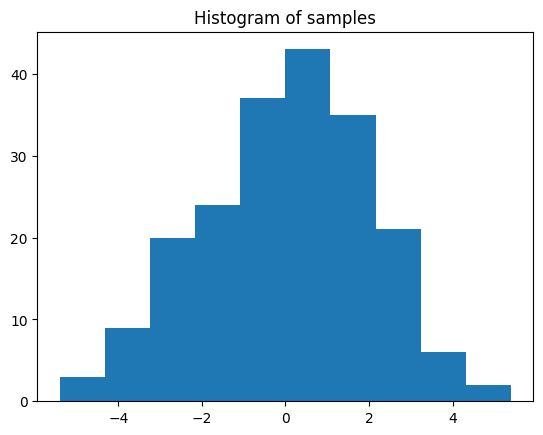

In [13]:
plt.title('Histogram of samples')
plt.hist(samples)
plt.show()

Not perfect but there appears to be a resemblance to N(1, 4). We can see that the bulk of the data is within $\sqrt{4}=2$ to either side of the mean and the sample variance confirms that, however the sample mean is closer to 0:

In [14]:
samples.mean(), samples.var()

(0.07018604583587632, 3.871754730075908)

b)

In [15]:
from scipy.stats import norm

true_likelihoods = np.apply_along_axis(norm(1, 2).pdf, 0, samples)
true_likelihoods /= np.sum(true_likelihoods)

hs = np.arange(0.2, 10.01, 0.1)


hypercube_pred_likelihoods = np.array([likelihood(samples, x, h, 'hypercube')
                                       for h in hs for x in samples]).reshape(len(hs), len(samples))

hypercube_pred_likelihoods /= np.sum(hypercube_pred_likelihoods, axis=1)[:, None]


gaussian_pred_likelihoods = np.array([likelihood(samples, x, h, 'gaussian')
                                      for h in hs for x in samples]).reshape(len(hs), len(samples))

gaussian_pred_likelihoods /= np.sum(gaussian_pred_likelihoods, axis=1)[:, None]

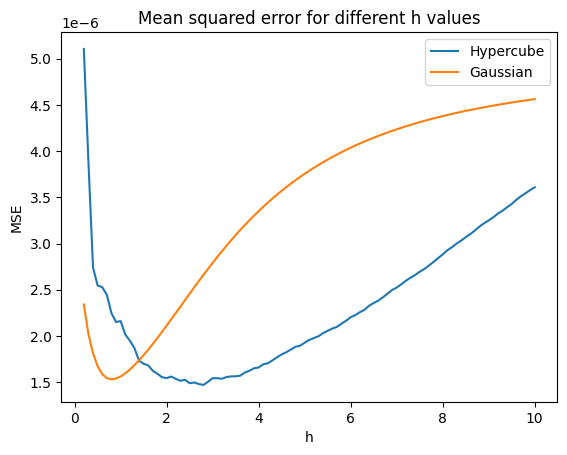

In [16]:
def mean_squared_error(true, pred):
    return np.sum((true - pred)**2) / len(true)

hypercube_mse = np.array([mean_squared_error(true_likelihoods, hypercube_pred_likelihoods[i])
                            for i in range(len(hs))])
gaussian_mse = np.array([mean_squared_error(true_likelihoods, gaussian_pred_likelihoods[i])
                            for i in range(len(hs))])

best_hypercube_pos = hypercube_mse.argmin()
best_gaussian_pos = gaussian_mse.argmin()

best_hypercube_h = hs[best_hypercube_pos]
best_gaussian_h = hs[best_gaussian_pos]

plt.title('Mean squared error for different h values')
plt.plot(hs, hypercube_mse, label='Hypercube')
plt.plot(hs, gaussian_mse, label='Gaussian')
plt.xlabel('h')
plt.ylabel('MSE')
plt.legend()
plt.show()

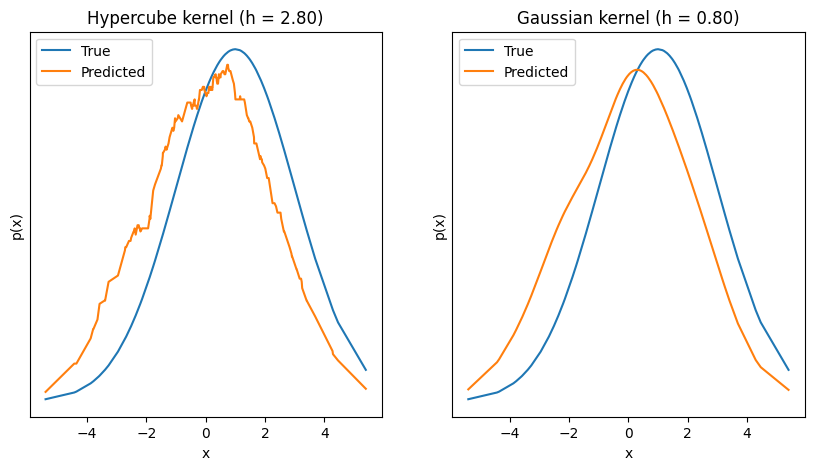

In [17]:
fig = plt.figure(figsize=(10, 5))
plt.subplots_adjust(hspace=0.5)

ax1 = fig.add_subplot(121)
ax1.set_title('Hypercube kernel (h = {:.2f})'.format(best_hypercube_h))
ax1.plot(samples, true_likelihoods, label='True')
ax1.plot(samples, hypercube_pred_likelihoods[best_hypercube_pos], label='Predicted')
ax1.set_xlabel('x')
ax1.set_ylabel('p(x)')
ax1.axes.get_yaxis().set_ticks([])
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.set_title('Gaussian kernel (h = {:.2f})'.format(best_gaussian_h))
ax2.plot(samples, true_likelihoods, label='True')
ax2.plot(samples, gaussian_pred_likelihoods[best_gaussian_pos], label='Predicted')
ax2.set_xlabel('x')
ax2.set_ylabel('p(x)')
ax2.axes.get_yaxis().set_ticks([])
ax2.legend()
plt.show()

We can see above how close the predicted distributions for the best value of h are to the true distribution. <br>
The shapes are very similar, however like mentioned before, the mean seems to be closer to 0 for the estimated distributions. <br>
The distributions are normalised for the sake of comparison, for this reason p(x) values are hidden.

## **Part C**

In [18]:
train = pd.read_csv('dataC_ΚΝΝtrain.csv', header=None)
train_data = train.iloc[:, :2].values
train_labels = train.iloc[:, 2].values

test = pd.read_csv('dataC_ΚΝΝtest.csv', header=None)
test_data = test.iloc[:, :2].values
test_labels = test.iloc[:, 2].values

#### 1.

In [19]:
def euclidean_distances(x, train_data):
    return np.sqrt(np.sum((x - train_data)**2, axis=1))

#### 2.

In [20]:
def k_nearest(x, train_data, k):
    dists = euclidean_distances(x, train_data)
    return np.argsort(dists)[:k]

#### 3.

In [21]:
def kNN(train_data, test_data, k):
    knearest = np.apply_along_axis(k_nearest, 1, test_data, train_data, k)
    labels = np.array([train_labels[i] for i in knearest])
    prob1 = np.sum(labels, axis=1) / k
    prob0 = 1 - prob1
    return np.array([prob0, prob1]).T

#### 4.

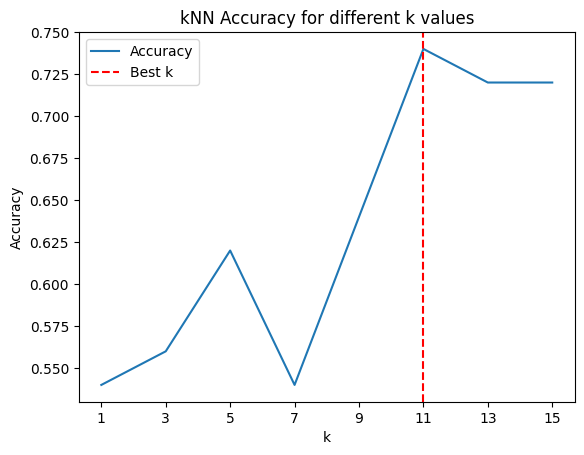

In [22]:
ks = np.arange(1, 16, 2)

def accuracy(true, pred):
    assert(len(true) == len(pred))
    return np.sum(true == pred) / len(true)

def predict(train_data, test_data, k):
    return np.argmax(kNN(train_data, test_data, k), axis=1)

predictions = np.array([predict(train_data, test_data, k) for k in ks])
accuracies = np.array([accuracy(test_labels, pred) for pred in predictions])

fig, ax = plt.subplots()
ax.set_xticks(ks)
ax.set_xlabel('k')
ax.set_ylabel('Accuracy')
ax.set_title('kNN Accuracy for different k values')
ax.plot(ks, accuracies)
ax.axvline(ks[np.argmax(accuracies)], color='red', linestyle='--')
ax.legend(['Accuracy', 'Best k'])
plt.show()

We can see that for k=11 we have the highest accuracy, and generally larger values of k (k>=9) tend to yield a higher accuracy than lower values.

#### 5.

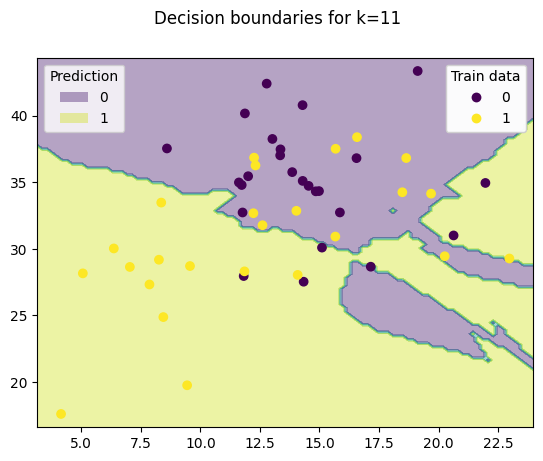

In [23]:
k = ks[np.argmax(accuracies)]

xlim = (np.min(train_data.T[0])-1, np.max(train_data.T[0])+1)
ylim = (np.min(train_data.T[1])-1, np.max(train_data.T[1])+1)
sample_rate = 100

x = np.linspace(xlim[0], xlim[1], sample_rate)
y = np.linspace(ylim[0], ylim[1], sample_rate)
xx, yy = np.meshgrid(x, y)
Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T

z = predict(train_data, Xgrid, k).reshape(xx.shape)

fig, ax = plt.subplots()

fig.suptitle(f'Decision boundaries for k={k}')
CS = ax.contourf(x, y, z, alpha=0.4)
h,_ = CS.legend_elements()
h = h[::len(h)-1]
classes = ['0', '1']
ax.add_artist(plt.legend(h, classes, loc='upper left', title='Prediction'))

scatter = ax.scatter(train_data.T[0], train_data.T[1], c=train_labels)
ax.add_artist(plt.legend(*scatter.legend_elements(), loc="upper right", title="Train data"))
plt.show()